# Exp020: Eliciting target grammar skills
This is an analysis for relationships between grammar skills that may be exploited for making learners produce desired output.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading

import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import torch
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as sps

import sys
sys.path.append(f'../source')
import data
import evaluation
import helpers
import models
import importlib
importlib.reload(helpers)

skills = helpers.get_high_conf_classifiers()
classifiers = {nr: models.load_classifier(nr, "corpus_training") for nr in skills}
classified_file = '../data/turn_classification.pkl'
primed_file ='../data/prime_stats.json'

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.1719747.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.1719747.dglandorf...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.1719747.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Load dialogs with their turns that we are interested in.

In [2]:
dialogs = data.get_dialog_data()
turns = helpers.flatten_list_of_lists([d[0] for d in dialogs])

The attention defines which other turns are of interest in this paradigm. Attention is only paid to next turns of the interlocutur.

In [ ]:
n_turns = [len(d[0]) for d in dialogs]
turn_attention = []
n_resp = 2
idx = 0
for length in n_turns:
    for i in range(0, length):
        attention = []
        for k in range(i, min(length-1, i+(2*n_resp-1)), 2): # only attend to next n response
            attention += [idx+k+1]
        turn_attention.append(attention)
    idx += length

Let's classify the grammar in all turns.

In [15]:
max_turns = int(1e10)
sentences = [(idx, sentence) for idx, turn in tqdm(enumerate(turns[:max_turns]), total=len(turns), desc="Sentence tokenization") for sentence in data.sent_tokenize(turn)]
indices, sents = [s[0] for s in sentences], [s[1] for s in sentences]

Sentence tokenization:   0%|          | 0/710640 [00:00<?, ?it/s]

In [12]:
tokenized_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
dataset = TensorDataset(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=512, shuffle=False)

clf_hits = {nr: [] for nr in skills}
for input_ids, attention_mask in tqdm(dataloader, desc="Grammar classification"):    
    input_ids, attention_mask = input_ids.to(models.device), attention_mask.to(models.device)
    with torch.no_grad():
        encoded_inputs = models.bert_encoder(input_ids, attention_mask) # encoding is the same for all classifiers
        x = torch.cat(encoded_inputs.hidden_states, dim=-1)
        for nr, clf in classifiers.items():
            max_values, _ = clf.forward_bert(x, attention_mask)
            clf_hits[nr] += (max_values>0.5).cpu().tolist()

with open(classified_file, 'wb') as f:
    pickle.dump(clf_hits, f)

Sentence tokenization:   0%|          | 0/710640 [00:00<?, ?it/s]

Grammar classification:   0%|          | 0/2371 [00:00<?, ?it/s]

In [16]:
with open(classified_file, 'rb') as f:
    clf_hits = pickle.load(f)

Transform the classification into one big indicator matrix

In [17]:
hits = np.zeros([sum(n_turns), len(skills)], dtype=bool)
for idx, (nr, clf_hit) in enumerate(clf_hits.items()):
    hit_indices = np.array(indices)[clf_hit]
    hits[hit_indices,idx] = 1

Calculate base rates

In [18]:
base_rate = hits.sum(axis=0)/min(max_turns, len(turns))
base_rate

array([0.0002941 , 0.01075509, 0.0044284 , 0.00390352, 0.00116937,
       0.00012946, 0.00939013, 0.0122453 , 0.05582433, 0.00396825,
       0.00505882, 0.00543876, 0.00704435, 0.00227541, 0.00202071,
       0.00289035, 0.0016844 , 0.00027159, 0.00093296, 0.00075144,
       0.00412023, 0.00024344, 0.04089835, 0.04483001, 0.01540724,
       0.01069177, 0.027077  , 0.01082123, 0.02725571, 0.0012932 ,
       0.00024204])

Do a significance test for a changed proportion of target skills after prime skills.

In [19]:
p_val = lambda z: (1 - norm.cdf(z)) # one-sided p-test

Iterate through the primes and count targets

In [98]:
all_stats = pd.DataFrame()
for idx, nr in enumerate(skills):
    print(nr)
    turns_with_skill = set(np.where(hits[:,idx])[0])
    antecedent_skills = np.vstack([hits[turn_attention[turn_nr],:].any(axis=0) for turn_nr in turns_with_skill])
    other_skills = np.vstack([hits[turn_attention[turn_nr],:].any(axis=0) for turn_nr in range(len(turns)) if turn_nr not in turns_with_skill and turn_nr+2 not in turns_with_skill])
    
    x1 = antecedent_skills.sum(axis=0)
    n1 = len(antecedent_skills)
    p1 = x1 / n1
    x2 = other_skills.sum(axis=0)
    n2 = len(other_skills)
    p2 = x2 / n2
    
    stats = pd.DataFrame({'prime': nr, "target": skills,
                          "x1":x1, "n1":n1, "p1":p1,
                          "x2":x2, "n2":n2, "p2":p2,
                          "p1-p2": p1-p2})
    all_stats = pd.concat([all_stats, stats])

    #p_pool = (x1 + x2) / (n1 + n2)
    #SE = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    #z = (p1 - p2) / SE
    #p = p_val(z)
    indices = np.where((p1-p2)>0.05)
    print(list(zip(np.array(skills)[indices], (p1-p2)[indices])))

57
[]
58
[]
59
[(619, 0.05517151756404602)]
69
[]
76
[(619, 0.08036823275103122)]
77
[(619, 0.05790910283707562)]
616
[(618, 0.06882724174979478), (619, 0.0505452864752504), (621, 0.05040137953874835)]
618
[(616, 0.05976340463734406), (618, 0.09141164875521098), (619, 0.09251231866726402)]
619
[(619, 0.11644785777734987)]
621
[(616, 0.13242198222524254), (618, 0.13460310497978145), (619, 0.1952559181658533)]
624
[(619, 0.12394187955191875)]
625
[(619, 0.16237630283761123)]
628
[(619, 0.19008928435543956)]
629
[(619, 0.11913369409137246)]
630
[(619, 0.12279070214630791)]
631
[(619, 0.11236684982459001)]
634
[(619, 0.06887603078948645)]
635
[(619, 0.08710085033340675), (625, 0.05209106972507497), (1176, 0.06339578735268539)]
636
[(619, 0.1110765530599654)]
1106
[]
1112
[(619, 0.17973786463180114)]
1116
[(625, 0.12868330059657274), (631, 0.11016558893300175), (1116, 0.09207586423835384), (1175, 0.13131698455446528), (1179, 0.11341397519703539)]
1175
[]
1176
[]
1177
[]
1178
[]
1179
[(1179,

Test for significant differences with Fisher's exact test

In [7]:
def get_p_value(row):
    table=[[row['x1'], row['n1']-row['x1']],
           [row['x2'], row['n2']-row['x2']]]
    odds_ratio, p_value = sps.fisher_exact(table, "greater")
    return pd.Series({'OR': odds_ratio, 'p': p_value})

In [99]:
all_stats[['OR', 'p']] = all_stats.apply(get_p_value, axis=1)

In [100]:
all_stats.reset_index(drop=True).to_json(primed_file)

## Read results from correlation analysis

In [14]:
all_stats = pd.read_json(primed_file)
all_stats = all_stats[all_stats['prime'].isin(skills)&all_stats['target'].isin(skills)]

In [15]:
alpha = 0.05 / len(all_stats)
print(alpha)

6.377551020408164e-05


In [16]:
egp = helpers.egp

In [25]:
def get_desc(nrs):
    egp_desc = egp.loc[nrs-1]
    return list(egp_desc['SubCategory'] + " - " + egp_desc['guideword'].str.replace('^.*?: ', '', regex=True))
all_stats['prime_desc'] = get_desc(all_stats['prime'])
all_stats['target_desc'] = get_desc(all_stats['target'])
all_stats[(all_stats['p']<alpha) & (all_stats['p1-p2']>0.05)].sort_values("p1-p2", ascending=False)[['prime_desc','target_desc','p2','p1','OR']]

,prime_desc,target_desc,p2,p1,OR
287,would - QUESTIONS WITH 'LIKE',would - AFFIRMATIVE,0.093042,0.288298,3.948676
380,would - QUESTIONS,would - AFFIRMATIVE,0.091772,0.281862,3.884278
349,would - AFTER 'IF' CLAUSES,would - AFFIRMATIVE,0.092475,0.254851,3.356436
286,would - QUESTIONS WITH 'LIKE',would - WISHES AND PREFERENCES WITH 'LIKE',0.016106,0.150709,10.840290
285,would - QUESTIONS WITH 'LIKE',would - AFFIRMATIVE WITH 'LIKE',0.012613,0.145035,13.279399
318,would - WISHES AND PREFERENCES,would - AFFIRMATIVE,0.093026,0.216968,2.701506
442,would - FUTURE IN THE PAST,would - AFFIRMATIVE,0.093783,0.216574,2.671255
411,would - WITH ADVERBS,would - AFFIRMATIVE,0.093606,0.212740,2.616638
256,would - AFFIRMATIVE,would - AFFIRMATIVE,0.081152,0.197600,2.788296
473,would - IMAGINED SITUATIONS IN THE PAST,would - AFFIRMATIVE,0.093573,0.205940,2.512290


What is the maximum prime per skill?!

In [29]:
max(all_stats[(all_stats['p']<alpha)]['OR'])

75.9280955873

In [36]:
all_stats[(all_stats['prime']==all_stats['target']) & (all_stats['p1-p2']>0.05)]

,prime,target,x1,n1,p1,x2,n2,p2,p1-p2,OR,p,prime_desc,target_desc
224,618,618,926,8702,0.106412,10407,693769,0.015001,0.091412,7.819518,0.000000e+00,would - WISHES AND PREFERENCES WITH 'LIKE',would - WISHES AND PREFERENCES WITH 'LIKE'
256,619,619,7839,39671,0.197600,51632,636235,0.081152,0.116448,2.788296,0.000000e+00,would - AFFIRMATIVE,would - AFFIRMATIVE
832,1179,1179,2071,19242,0.107629,30312,673323,0.045019,0.062611,2.558517,2.394976e-270,"negation - AUXILIARY VERB 'DO', PAST","negation - AUXILIARY VERB 'DO', PAST"


In [19]:
df = pd.DataFrame({"Number of tests": [len(all_stats)],
             "Significant tests": [len(all_stats[all_stats['p']<alpha])],
              "Average frequency difference": [np.mean(all_stats[all_stats['p']<alpha]['p1-p2'])],
              "Average odds ratio": [np.mean(all_stats[all_stats['p']<alpha]['OR'])],
              "\Delta >0.05": [np.mean(all_stats[all_stats['p']<alpha]['p1-p2']>0.05)],
             }).reset_index(drop=True)
df

,Number of tests,Significant tests,Average frequency difference,Average odds ratio,\Delta >0.05
0,784,191,0.026394,2.98643,0.115183


In [21]:
latex_table = df.transpose().to_latex(column_format="lr", escape=False, float_format="%.3f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Number of tests & 784.000 \\
Significant tests & 191.000 \\
Average frequency difference & 0.026 \\
Average odds ratio & 2.986 \\
\Delta >0.05 & 0.115 \\
\bottomrule
\end{tabular}



## Establish causality by simulating an intervention

Now let's use one of them in a random dialog context and simulate the next answer.

In [5]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")#"/cluster/home/dglandorf/models/llama-FT")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Sample random contexts and override the constraint

In [6]:
n = 16
nr = 621
cases = pd.DataFrame([helpers.sample_dialog_snippet(dialogs) for _ in range(n)])
cases.columns = ['context','response','source','id']
cases['constraints']=[[nr]] * n
cases = cases.apply(lambda x: helpers.get_generation_prompt(x, tokenizer.apply_chat_template, system_msg=True), axis=1)

Generate constrained answers

In [31]:
cases['response'] = models.generate(model, tokenizer, list(cases['prompt']), verbose=False, do_sample=False, eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")], batch_size=8)

Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.40s/it]


Append the answers to the context that fulfill the constraint and create prompts for an unconstrained answer to simulate the learner

In [32]:
print(len(cases))
cases = cases[(models.probe_model(classifiers[nr], list(cases['response']))[0] > 0.5).numpy()]
print(len(cases))

16
16


In [33]:
cases['context'] = cases.apply(lambda x: x['context'] + [helpers.parse_response(x['response'])], axis=1)
cases['CEFR'] = egp.loc[nr-1]['Level']
cases = cases.apply(lambda x: helpers.get_CEFR_prompt(x, tokenizer.apply_chat_template, system_msg=False), axis=1)
#cases = cases.apply(lambda x: helpers.get_generation_prompt(x, tokenizer.apply_chat_template, system_msg=True, unconstrained=True), axis=1)

In [36]:
print(cases['prompt'][9])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output B's response using language on CEFR level A2. This level is described as: Can interact with reasonable ease in structured situations and short conversations, provided the other person helps if necessary. Can manage simple, routine exchanges without undue effort; can ask and answer questions and exchange ideas and information on familiar topics in predictable everyday situations.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of B that an English learner on CEFR level A2 could produce:
Dialog:
A: It's my my breath it's hers. Should I just wait until she come at me with a kissy face and throw a tic tack in her mouth?
B: Tic tacs can help but i would recommend you encourage her to practice good oral hygiene instead
A: I've been trying but telling my wife she has bad hygiene is a good way to get my self in trouble. But people have been French Kissing for ever I want to 

Generate next response again

In [37]:
cases['response'] = models.generate(model, tokenizer, list(cases['prompt']), batch_size=8)

Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.87s/it]


In [39]:
cases['context'] = cases.apply(lambda x: x['context'] + [helpers.parse_response(x['response'], "B: ")], axis=1)

In [43]:
cases['context'].sample(1).iloc[0]

["me too i love it what's you find interressant \nabout the movie",
 'I love how they used different animals in the movie as a way to portray different kind of people',
 'Like the slow sloths at the DMV that part was hilarious and so true, if we were animals the workers at the DMV would totally be sloths',
 'yes so true ',
 'Would you like to see a sequel to this movie?',
 "Yeah, I would like to see a sequel. I think it's a good idea to see what happens to the animals after the movie ends."]

Test for target structures

In [35]:
for nr in primed[nr]:
    print(nr)
    print((models.probe_model(classifiers[nr], list(cases['response']))[0]>0.5).float().mean())

616
tensor(0.0635)
618
tensor(0.0794)
619
tensor(0.6667)


Now as a loop for all primes

In [41]:
n=32


In [51]:
def generate_responses(cases):
    cases['response'] = models.generate(model, tokenizer, list(cases['prompt']), verbose=False, do_sample=False, batch_size=8)

In [52]:
def sample_succesful(constraint, n=8):
    cases = pd.DataFrame([helpers.sample_dialog_snippet(dialogs) for _ in range(n)])
    cases.columns = ['context','response','source','id']
    cases['constraints'] = [[constraint]] * n
    cases = cases.apply(lambda x: helpers.get_generation_prompt(x, tokenizer.apply_chat_template, system_msg=True), axis=1)
    generate_responses(cases)
    success = (models.probe_model(classifiers[constraint], list(cases['response']))[0] > 0.5).numpy()
    print(success.mean())
    return cases[success]

In [35]:
relevant = all_stats[(all_stats['p']<alpha) & (all_stats['p1-p2']>0.05)].copy()

In [10]:
relevant['ratio']=0

In [24]:
prime_nr=619
nr=619

In [36]:
len(relevant)

28

In [28]:
relevant.loc[(relevant['prime']==prime_nr) & (relevant['target']==nr),'ratio']=1


In [32]:
(models.probe_model(classifiers[nr], ["I'd do that."])[0]>0.5).float().mean().item()

1.0

In [55]:
all_cases = pd.DataFrame()
for prime_nr in relevant['prime'].unique():
    print(prime_nr)
    ratios[prime_nr] = {}
    cases = pd.DataFrame()
    attempts = 0
    while len(cases) < 32 and attempts < 16:
        cases = pd.concat([cases, sample_succesful(prime_nr)], ignore_index=True)
        attempts += 1
    if not len(cases): continue
    cases['context'] = cases.apply(lambda x: x['context'] + [x['response'].replace("A: ", "")], axis=1)
    print(cases['context'].sample(1).iloc[0])
    cases = cases.apply(lambda x: helpers.get_generation_prompt(x, tokenizer.apply_chat_template, unconstrained=True, system_msg=True), axis=1)
    cases['response'] = models.generate(model, tokenizer, list(cases['prompt']), batch_size=8)
    
    for nr in relevant[relevant['prime']==prime_nr]['target']:
        print(nr)
        ratios[prime_nr][nr] = (models.probe_model(classifiers[nr], list(cases['response']))[0]>0.5).float().mean()
        print(ratios[prime_nr][nr])

59


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.99s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.69s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.25s/it]


0.75


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.56s/it]


0.75


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


0.5
['It has got around 89% of rotten tomatoes rating if you prefer watching movies having good ratings.', 'hmmmm, i know it might be completely different in genre but this brings me back to times of THE CHRONICLES OF NARNIA', 'Wow 89% really is a high number. what else do you have for me this is getting interesting.', 'Critics have raved it as the best-animated musical to come out of Disney. This movie has so many likable characters like; the rugged iceman, the reindeer, and a naive snowman.', "That's amazing! I've heard it's the most popular animated movie in Disney's history, and I've always wanted to see it."]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.55s/it]


619
tensor(0.1143)
76


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


0.25


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.04s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.68s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.65s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.21s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.54s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.59s/it]


0.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


0.25


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


0.0
["I feel like going for a drink, it's been a long day.", 'Great idea! Peter, I could use the drink.', 'How about the new bar across road?', 'Sounds good. The food there is fantastic, too.', "That's the best place to go, I think, to relax and unwind after a day like this."]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.22s/it]


619
tensor(0.)
616


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.81s/it]


0.75


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


0.875


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.48s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


0.625
['Thank you, Rick! As you can see, ladies and gentleman, we are here in beautiful Pebble Beach where the top golfers in the world are trying to win the grand prize of one million dollars!', "Whoa, that's a lot of cash! Let's go to the course and see how Tiger Woods is doing.", "All right, we are here at the eighth hole. It's a par four, and has some very difficult hazards which many golfers find difficult to avoid. Although, I did see Jack Nicklaus hit a hole in one on this very same hole!", "Tiger Woods is about to tee off, and let's see if he has the same luck as Jack. Tiger is asking his caddie for his driver and, he seems to be very nervous.", "I would like to get a closer look at Tiger's swing and see if he can overcome his nerves and hit a great shot."]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]


618
tensor(0.0938)
619
tensor(0.1562)
621
tensor(0.0312)
618


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.62s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


0.625


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


1.0
["It's crazuy", 'Just imagine a world with the Thought Police stopping you from thinking as an independent person. It would be sad. ', 'Yes, it would, when was the book released?', 'That sweet little dystopian novel was published in 1949. ', 'I would like to read it, it sounds really interesting.']


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.18s/it]


616
tensor(0.0270)
618
tensor(0.0541)
619
tensor(0.2162)
619


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.76s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


1.0
['Yeah they just need to focus on their citizens and provide for them. North Korea is also a tough place to live too. Kim Jong-un needs to better lead the workers party.', 'NK is a mess and will collapse. people are starving. how long can this last?', "That's a good question. We also don't actually know how old Kim Jong-un is!", 'He likes his mysteries. Everything about him sounds fishy.', 'I would think that if Kim Jong-un would focus more on the economy and less on his military, things would start to improve in North Korea.']


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.13s/it]


619
tensor(0.0938)
621


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


1.0
['I wonder what they\'d make of me if I start playing "All I Want For Christmas", constantly in March.  They\'d probably just think I was a lunatic.', 'Or maybe that you were thinking ahead.', 'Maybe I should really think ahead and get my Holiday shopping done now, play that song, and put up the tree.', 'I know people who start shopping after labor day', 'Would you like to join me in my holiday preparations, or are you going to stick to your post-Labor Day shoppers?']


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.69s/it]


616
tensor(0.0312)
618
tensor(0.0312)
619
tensor(0.6875)
624


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


1.0


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.30s/it]


0.75


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.89s/it]


0.625


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.43s/it]


0.75


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.42s/it]


1.0
['Do you know much about their durability?  I know Hondas and Toyotas have a great reputation, but not so sure about the Chevrolets.', 'I like how Chevrolet has been around for a long time. The company was started in 1911 by Louis Chevrolet and William C Durant.', 'That certainly is a long time.  What type of car are you looking into?', "Possibly a truck. Chevrolet originally started to compete with Ford's Model T. It then became the best selling car by 1929.", "I would prefer a truck with a good fuel economy, so I'm looking at the Chevrolet Silverado."]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.87s/it]


619
tensor(0.1515)
625


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


0.125


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


0.375


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.83s/it]


0.25


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


0.5


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


0.625
['Greece, officially known as the Hellenic Republic, has such a rich history.', 'Yes, it really does.  The cradle of democracy.  I studied a lot of Greek philosophy in school.', 'Oh, same, I learned about the Greco-Persian Wars which lasted from 5th to 4th centuries BC. What about you?', 'The wars are fascinating. Thermopylae and the Spartans stand are very cool.  ', "If I were you, I would definitely visit the Acropolis in Athens, it's an incredible piece of history."]


Generate:  20%|████████████████████████                                                                                                | 1/5 [00:14<00:59, 14.81s/it]


KeyboardInterrupt: 

In [5]:
def get_p_value(row, suffix=""):
    col_name = f'num_success{suffix}'
    table=[[row[col_name], row['num_simulated']-row[col_name]],
           [row['x2'], row['n2']-row['x2']]]
    odds_ratio, p_value = sps.fisher_exact(table, "greater")
    return pd.Series({'OR': odds_ratio, 'p': p_value})

def plot_priming(file="intervention/intervention_level", title='Test for causality of prime-target pairs', suffix="", up_to_level=None):
    sim = pd.read_json(f'../data/{file}.json')
    if up_to_level: # filter for too difficult levels
        sim['Level'] = helpers.egp.loc[sim.target-1].Level.reset_index(drop=True)
        sim['Level_Order'] = sim['Level'].map(helpers.level_order)
        sim = sim[sim['Level_Order']<=helpers.level_order[up_to_level]].copy()
    sim['p3'] = sim[f'num_success{suffix}'] / sim['num_simulated']
    sim[['OR', 'p']] = sim.apply(get_p_value, axis=1, suffix=suffix)
    sim['pair'] = sim['prime'].astype(str) + "->" + sim['target'].astype(str)
    sim.set_index('pair', inplace=True)
    fig, ax = plt.subplots(figsize=(16, 6))  # Adjust the figsize as needed
    
    sim[['p2', 'p1', 'p3']].plot(kind='bar', ax=ax, legend=True)
    ax.legend(['Target without prime', 'Target after prime in observation', 'Target after prime in intervention'])
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.xlabel('Prime-target pair (red=significant)')
    plt.xticks(rotation=30, ha='right')
    plt.ylabel('Frequency')
    plt.title(title)
    tick_labels = ax.get_xticklabels()
    for tick_label in tick_labels:
        if sim.loc[tick_label.get_text()].name in list(sim[sim['p']<0.05/len(sim)].index):
            tick_label.set_color('red')
    plt.show()



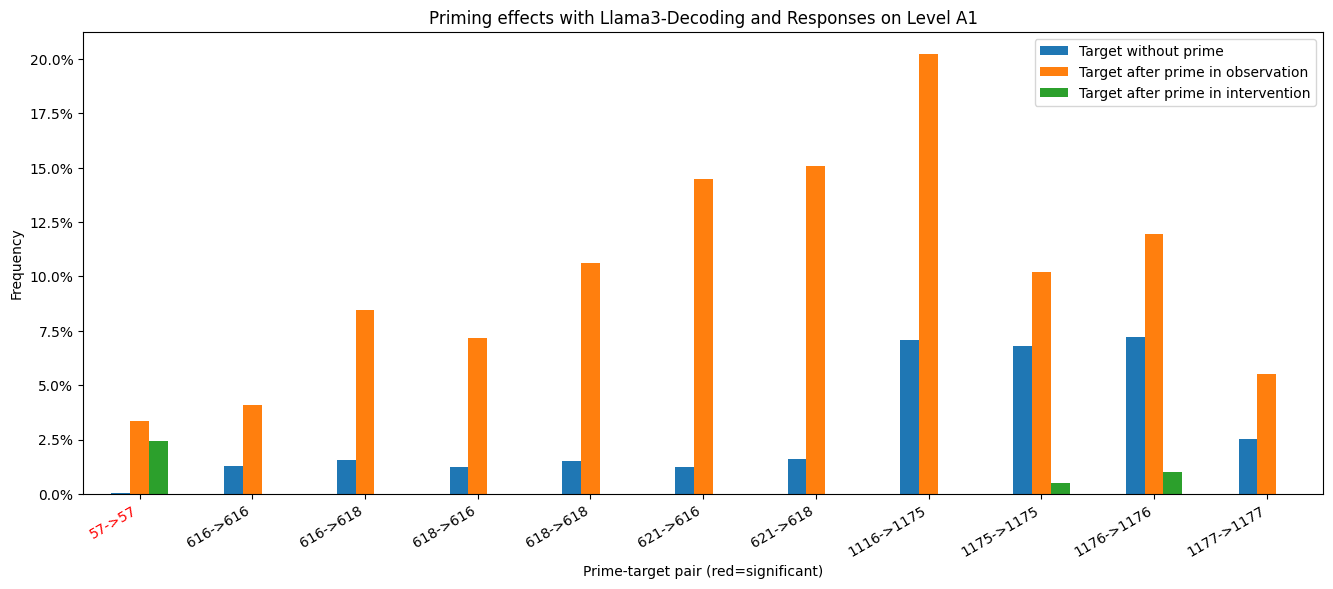

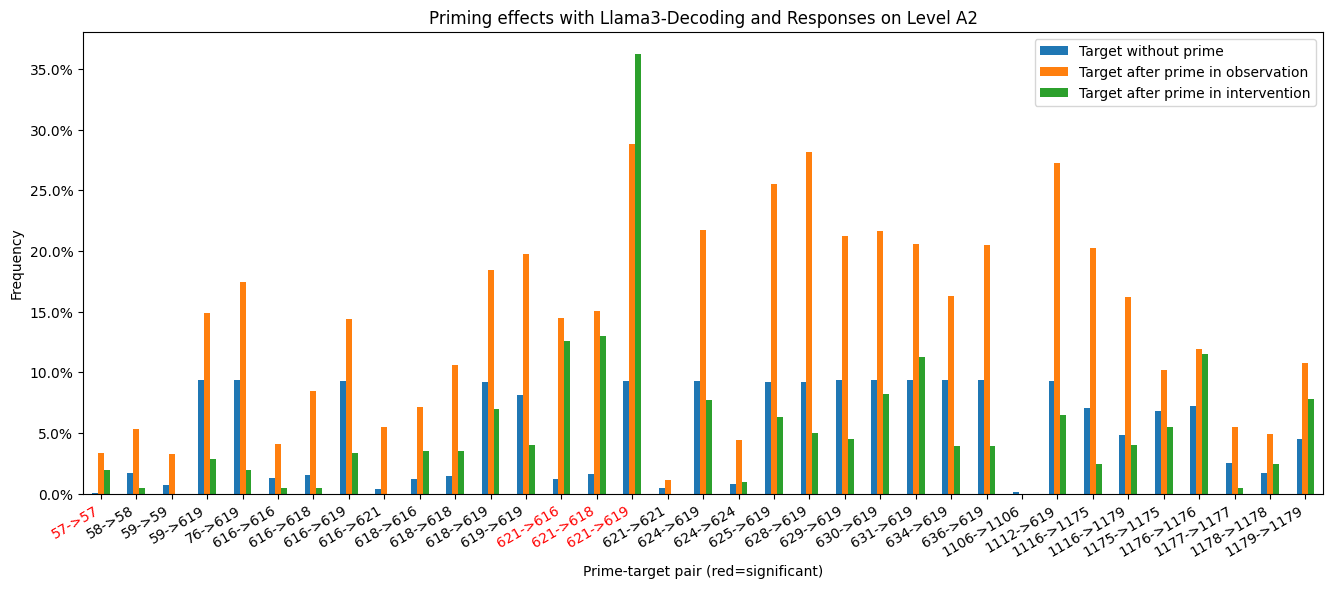

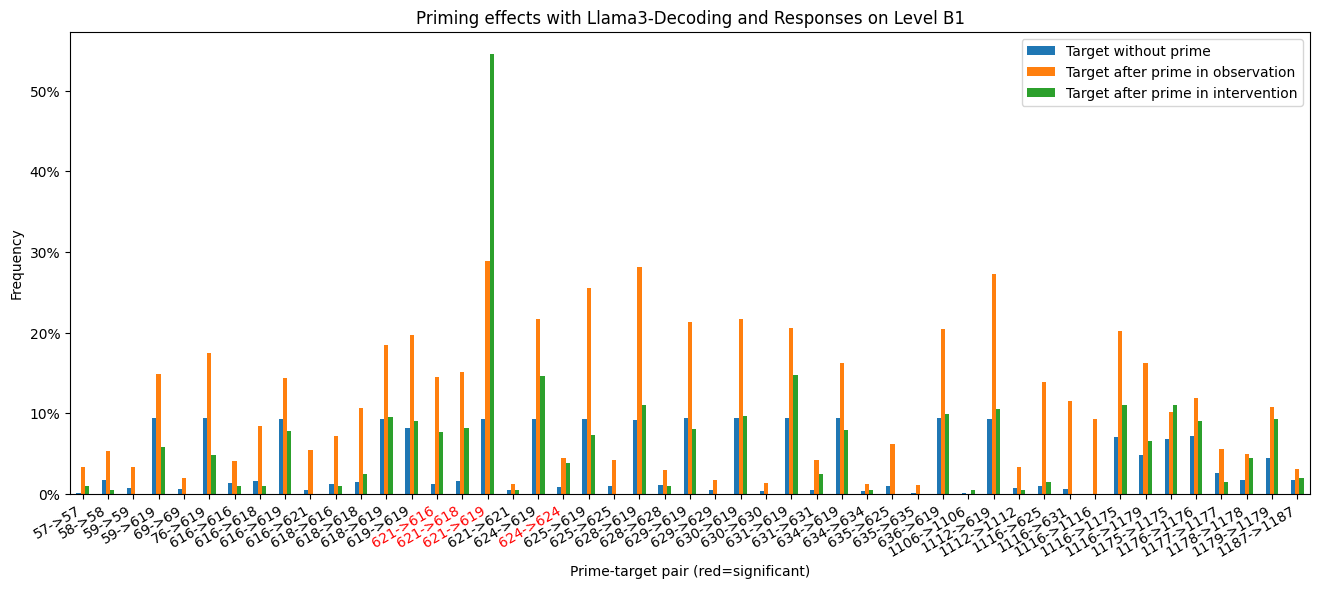

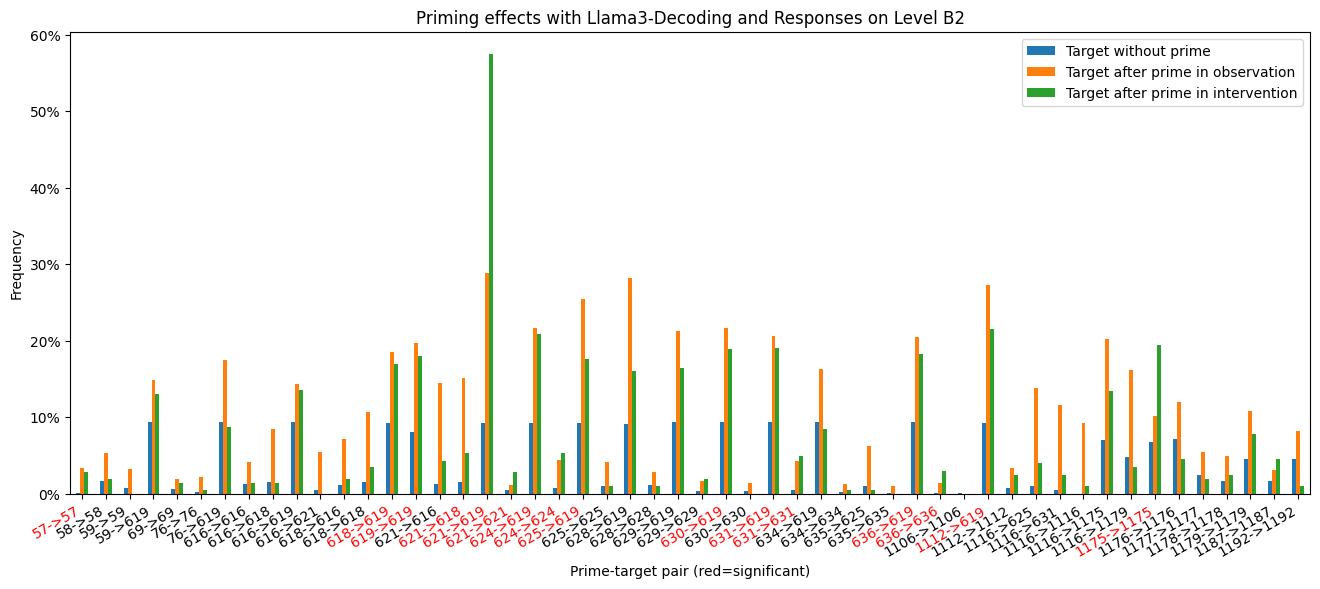

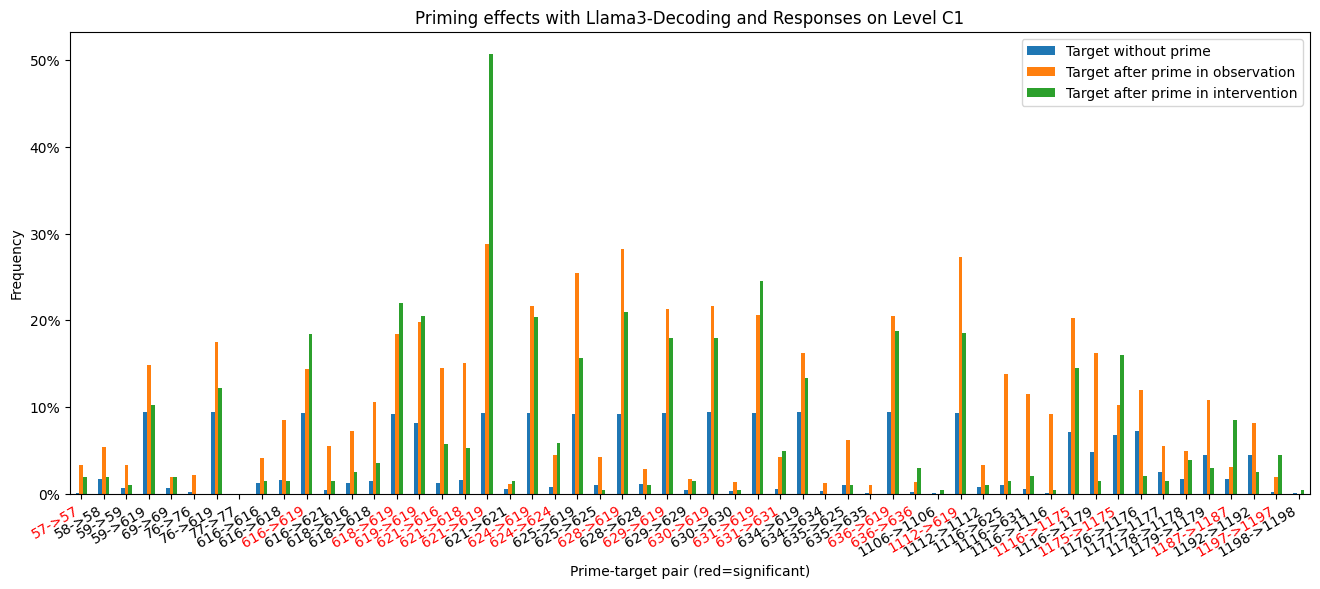

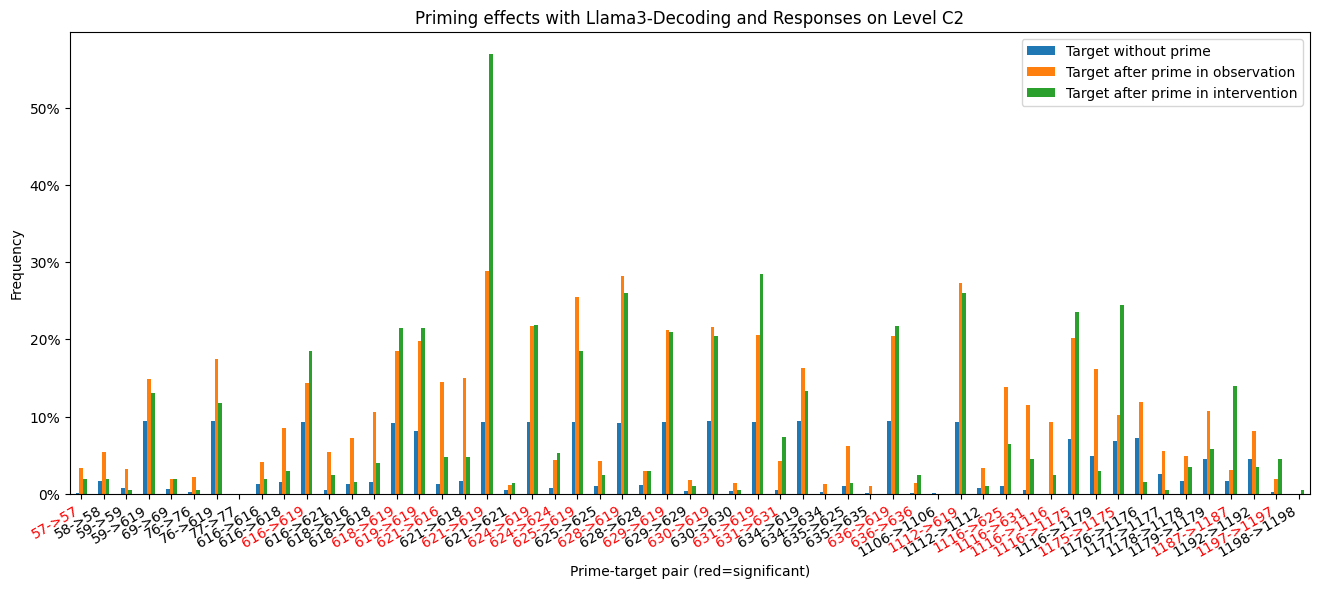

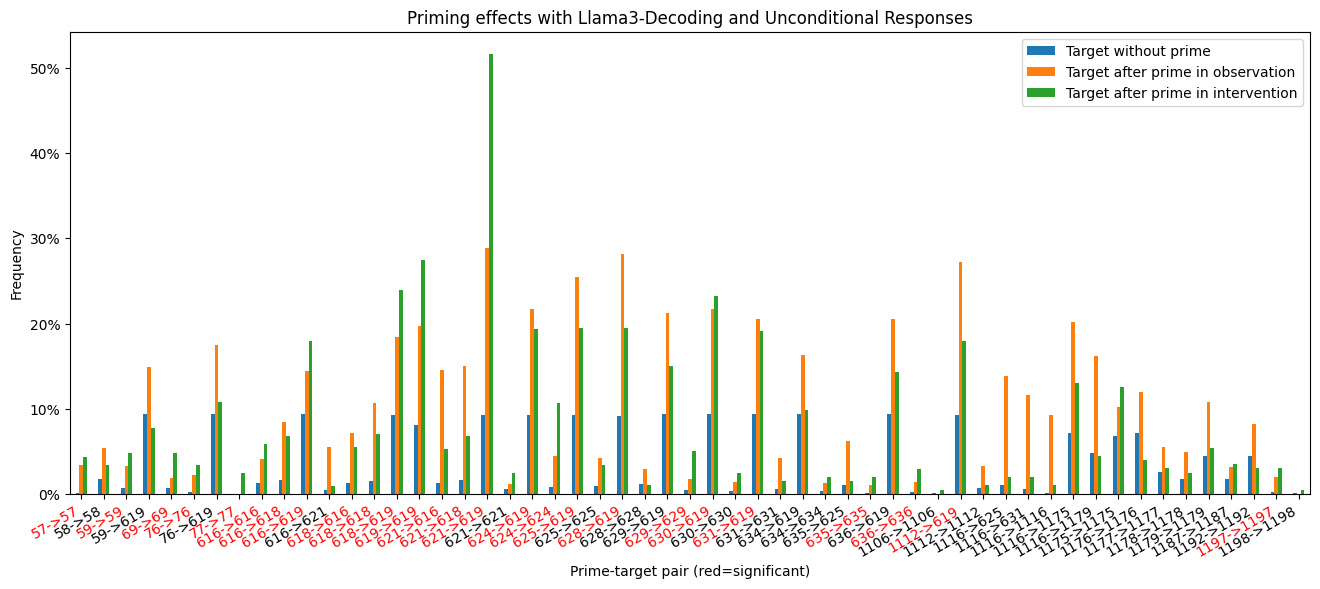

In [20]:
for level in ["A1", "A2", "B1", "B2", "C1", "C2"]:
    plot_priming("intervention/intervention-llama2", "Priming effects with Llama3-Decoding and Responses on Level "+level, "_"+level, level)
plot_priming("intervention/intervention-llama2", "Priming effects with Llama3-Decoding and Unconditional Responses", "_unconditional")

In [6]:
def get_significant(sim, level):
    sim['p3'] = sim[f'num_success_{level}'] / sim['num_simulated']
    sim[['OR', 'p']] = sim.apply(get_p_value, axis=1, suffix=f"_{level}")
    return sim['p']<0.05/len(sim), sim['OR'] # sim['p3'] - sim['p2']

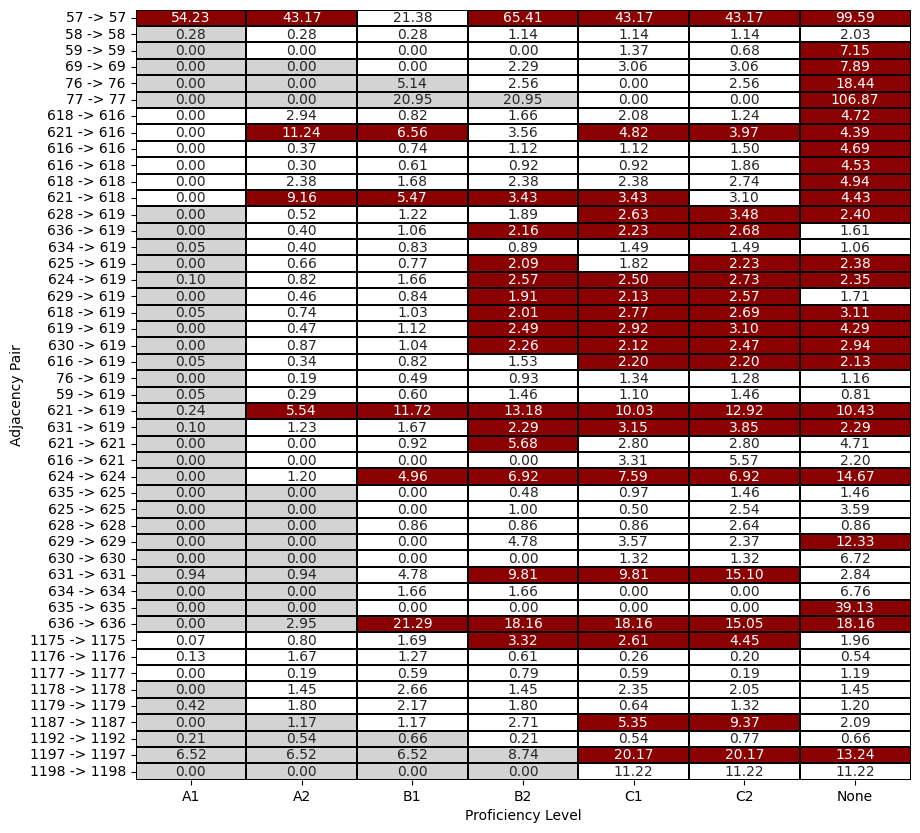

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

levels = ["A1", "A2", "B1", "B2", "C1", "C2", "unconditional"]
sim = pd.read_json(f'../data/intervention/intervention-llama2.json')
sim2 = sim[(sim['prime'].isin(skills)) & (sim['target'].isin(skills))].copy()
sim2['Level'] = helpers.egp.loc[sim['target']-1].Level.reset_index(drop=True)
sim2['Level_Order'] = sim2['Level'].map(helpers.level_order)

sim2['pair'] = sim2['prime'].astype(str) + " -> " + sim2['target'].astype(str)
sim2.set_index('pair', inplace=True)
sim2 = sim2.sort_values(by='target')

df = pd.DataFrame({level: get_significant(sim2, level)[0] for level in levels})
p_val = pd.DataFrame({level: get_significant(sim2, level)[1] for level in levels})
possible = pd.DataFrame({level: sim2['Level_Order'] <= helpers.level_order[level] for level in levels[:-1]})
possible['unconditional'] = True

df = df.astype(int)
df[~possible & ~df] = 2

colors = ['white', 'darkred', 'lightgrey']
color_map = ListedColormap(colors)
fig, ax = plt.subplots(figsize=(10, 10))
# 
sns.heatmap(df, annot=p_val, cmap=color_map, cbar=False, fmt='.2f', linewidths=.25, ax=ax, linecolor="black", xticklabels=True, yticklabels=True)
ax.set_ylabel("Adjacency Pair")
ax.set_xlabel("Proficiency Level")
ax.set_xticklabels(levels[:-1] + ["None"], rotation=0)
plt.savefig("../results/intervention.pdf")
plt.show()

Plot simplfied version

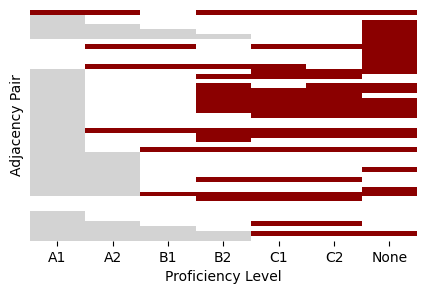

In [12]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(df, cmap=color_map, cbar=False, fmt='.2f', ax=ax, linecolor=None, xticklabels=True, yticklabels=False)
ax.set_ylabel("Adjacency Pair")
ax.set_xlabel("Proficiency Level")
ax.set_xticklabels(levels[:-1] + ["None"], rotation=0)
plt.savefig("../results/intervention_simple.pdf")
plt.show()

In [14]:
df = pd.DataFrame({level: get_significant(sim2, level)[0] for level in levels})
df.sum(axis=0)

A1                1
A2                4
B1                5
B2               16
C1               19
C2               19
unconditional    25
dtype: int64

In [134]:
len(df)

47

In [18]:
(df.sum(axis=1)>0).sum()

31